# **BENG 249 Final Project**
# Analysis of COVID-19 Disparities: Testing Rates, Racial Inequities, and Outcomes
## Meso Ezebuiro and Hawa Khalif


In [2]:
import numpy as np
import random
import numpy.random as npr
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from google.colab import drive
drive.mount('/content/drive')

import csv


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/nevada-race-ethnicity-historical.csv')
df

,State,Date,Cases_Asian,Cases_AIAN,Cases_Black,Cases_White,Cases_Other,Cases_NHPI,Cases_Multiracial,Cases_LatinX,...,Tests_Black,Tests_Ethnicity_Hispanic,Tests_Ethnicity_NonHispanic,Tests_Ethnicity_Unknown,Tests_LatinX,Tests_Multiracial,Tests_NHPI,Tests_Other,Tests_White,Tests_Total
0,NV,20210307,24287.0,1480.0,22510.0,108109.0,33173.0,NaN,NaN,106628.0,...,137083.0,249890.0,1178055.0,3.0,249890.0,NaN,NaN,254174.0,675419.0,1427948.0
1,NV,20210303,23893.0,1474.0,22418.0,107372.0,33627.0,NaN,NaN,105897.0,...,136080.0,248063.0,1169441.0,3.0,248063.0,NaN,NaN,252316.0,670480.0,1417507.0
2,NV,20210228,23794.0,1468.0,22325.0,107220.0,33781.0,NaN,NaN,105163.0,...,135589.0,245756.0,1165224.0,3.0,245756.0,NaN,NaN,251406.0,668063.0,1410983.0
3,NV,20210224,23656.0,1460.0,22196.0,106601.0,34170.0,NaN,NaN,103973.0,...,134479.0,243744.0,1157084.0,3.0,243744.0,NaN,NaN,250748.0,662593.0,1400831.0
4,NV,20210221,23277.0,1454.0,22113.0,106204.0,34625.0,NaN,NaN,103295.0,...,133586.0,240734.0,1152182.0,2.0,240734.0,NaN,NaN,251866.0,658192.0,1392918.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,NV,20200426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NV,20200422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NV,20200419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NV,20200415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Question 1: Were communities of color disproportionately affected compared to white populations?

In [3]:
import pandas as pd
import numpy as np


df = pd.read_csv('/content/drive/My Drive/nevada-race-ethnicity-historical.csv')

# 1. Calculate proportions
df['Total_Cases'] = df[[c for c in df.columns if 'Cases_' in c]].sum(axis=1)
for race in ['Cases_White', 'Cases_Black', 'Cases_Asian', 'Cases_AIAN', 'Cases_LatinX']:
    if race in df.columns:
        df[f'{race}_Prop'] = df[race] / df['Total_Cases']

# 2. zscore analysis to compare each group to population distribution
results = []
for poc in ['Black', 'Asian', 'AIAN', 'LatinX']:
    if f'Cases_{poc}_Prop' in df.columns:
        all_props = df[[f'Cases_{poc}_Prop', 'Cases_White_Prop']].dropna().values.flatten()
        population_mean = np.mean(all_props)
        population_std = np.std(all_props, ddof=1)

        poc_prop = df[f'Cases_{poc}_Prop'].mean()
        white_prop = df['Cases_White_Prop'].mean()

        # z-scores for each group's mean proportion
        z_poc = (poc_prop - population_mean) / population_std
        z_white = (white_prop - population_mean) / population_std
        z_diff = z_poc - z_white

        # if the disparity is meaningful (>1 SD or <-1 SD)
        meaningful = abs(z_diff) >= 1.0

        results.append({
            'Group': poc,
            'Mean_Prop': poc_prop,
            'White_Prop': white_prop,
            'Z_Score': z_poc,
            'Z_vs_White': z_diff,
            'Meaningful_Disparity': meaningful
        })

# 3. results
results_df = pd.DataFrame(results)
print("\n=== PROPORTION ANALYSIS (Z-SCORES) ===")
print(results_df.to_markdown(index=False))

# 4. interpretation
print("\nCONCLUSION:")
for _, row in results_df.iterrows():
    if row['Meaningful_Disparity']:
        disparity = "overrepresented" if row['Z_vs_White'] > 0 else "underrepresented"
        print(f"- {row['Group']} was {disparity} relative to White population "
              f"(disparity magnitude={abs(row['Z_vs_White']):.2f} SD)")
    else:
        print(f"- No meaningful disparity for {row['Group']} (disparity magnitude={abs(row['Z_vs_White']):.2f} SD)")

if any(row['Meaningful_Disparity'] and row['Z_vs_White'] > 0 for _, row in results_df.iterrows()):
    print("\nMeaningful overrepresentation in cases found in some communities of color")


=== PROPORTION ANALYSIS (Z-SCORES) ===
| Group   |   Mean_Prop |   White_Prop |   Z_Score |   Z_vs_White | Meaningful_Disparity   |
|:--------|------------:|-------------:|----------:|-------------:|:-----------------------|
| Black   |  0.0229137  |    0.0897308 | -0.926549 |    -1.8531   | True                   |
| Asian   |  0.0218657  |    0.0897308 | -0.927916 |    -1.85583  | True                   |
| AIAN    |  0.00152341 |    0.0897308 | -0.955772 |    -1.91154  | True                   |
| LatinX  |  0.107012   |    0.0897308 |  0.466178 |     0.932357 | False                  |

CONCLUSION:
- Black was underrepresented relative to White population (disparity magnitude=1.85 SD)
- Asian was underrepresented relative to White population (disparity magnitude=1.86 SD)
- AIAN was underrepresented relative to White population (disparity magnitude=1.91 SD)
- No meaningful disparity for LatinX (disparity magnitude=0.93 SD)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Question 2: Do higher testing rates correlate with lower adverse outcomes?

Data Analysis

Group         Slope        Slope Ratio     Corr (r)         R²
-----------------------------------------------------------------
Total           nan                nan          nan        nan
White           nan                nan          nan        nan
Black           nan                nan          nan        nan
LatinX          nan                nan          nan        nan
Asian           nan                nan          nan        nan
AIAN            nan                nan          nan        nan
Other           nan                nan          nan        nan


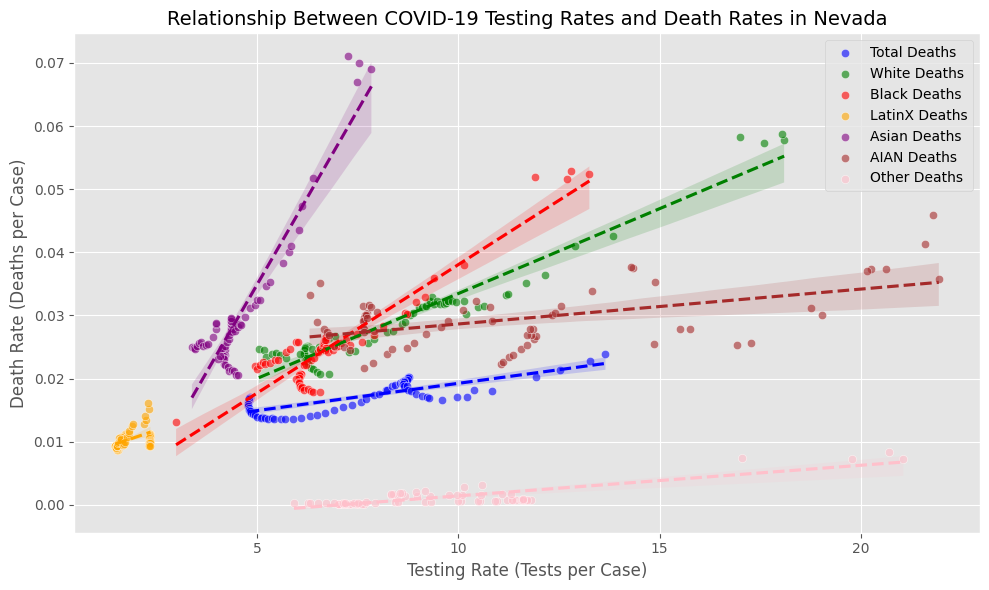

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define groups
groups = ['Total', 'White', 'Black', 'LatinX', 'Asian', 'AIAN', 'Other']

# Define colors
colors = {'Total': 'blue', 'Black': 'red', 'White': 'green','LatinX': 'orange', 'Asian': 'purple', 'AIAN': 'brown', 'Other': 'pink'}

# Calculate death and testing rates
for group in groups:
    death_col = f'Deaths_{group}'
    case_col = f'Cases_{group}'
    test_col = f'Tests_{group}'

    df[f'{group}_Death_Rate'] = df[death_col] / df[case_col]
    df[f'{group}_Testing_Rate'] = df[test_col] / df[case_col]

# Compute slopes, correlations, R², and slope ratios
results = {}
for group in groups:
    death_rate_col = f'{group}_Death_Rate'
    testing_rate_col = f'{group}_Testing_Rate'

    m, b, r, _, _ = stats.linregress(df[testing_rate_col], df[death_rate_col])
    r_squared = r ** 2

    results[group] = {'slope': m,'intercept': b,'r_value': r,'r_squared': r_squared}

# Printing results
total_slope = results['Total']['slope']
print("Data Analysis")
print("\n{:<8} {:>10} {:>18} {:>12} {:>10}".format("Group", "Slope", "Slope Ratio", "Corr (r)", "R²"))
print("-" * 65)
for group in groups:
    slope = results[group]['slope']
    r = results[group]['r_value']
    r2 = results[group]['r_squared']
    slope_ratio = slope / total_slope
    print(f"{group:<8} {slope:>10.6f} {slope_ratio:>18.6f} {r:>12.4f} {r2:>10.4f}")

# Plotting
plt.figure(figsize=(10, 6))
for group in groups:
    sns.scatterplot(
        x=f'{group}_Testing_Rate',
        y=f'{group}_Death_Rate',
        data=df,
        label=f'{group} Deaths',
        color=colors[group],
        alpha=0.6
    )
    sns.regplot(
        x=f'{group}_Testing_Rate',
        y=f'{group}_Death_Rate',
        data=df,
        scatter=False,
        color=colors[group],
        line_kws={"linestyle": "--"}
    )

plt.title('Relationship Between COVID-19 Testing Rates and Death Rates in Nevada', fontsize=14)
plt.xlabel('Testing Rate (Tests per Case)')
plt.ylabel('Death Rate (Deaths per Case)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()